In [33]:
#Importing stuff
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from reg_utils import plot_decision_boundary, load_2D_dataset, predict_dec
import sklearn
import sklearn.datasets
import scipy.io
from testCases import *

get_ipython().magic('matplotlib inline')
plt.rcParams['figure.figsize'] = (7.0, 4.0) # set default size of plots
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

In [34]:
def model(X, Y, nn_structure, num_iterations=3000, learning_rate=0.01, printCost = False, lambd = 0, dropOutProb = 1):
    
    costs = []
    
    #initialize the parameters
    parameters = initializieParameters(nn_structure)
    
    for i in range(num_iterations):
        #forward propagation
        AL, cache = forwardPropagation(X, parameters, dropOutProb)
        
        #caculate cost
        cost = calculateCost(AL, Y, parameters, lambd)
        costs.append(cost)
        if printCost and i%100 == 0:
            print("cost after iteration " + str(i) + " is " + str(cost))
        
        #backpropagation
        grads = backpropagation(AL, Y, cache, dropOutProb, lambd)
        
        #update parameters
        parameters  = updateParameters(parameters, grads, learning_rate)
    
    return parameters

def predict(X, Y, parameters):
    A, cache = forwardPropagation(X, parameters)
    m = Y.shape[1]
    p = np.zeros((1, Y.shape[1]), dtype=float)
    for i in range(m):
        if A[0][i] >= 0.5:
            p[0][i] = 1.0
        else:
            p[0][i] = 0.0
    
    print("Accuracy: " + str(np.sum((p == Y)/m)))
    return p

ValueError: c of shape (1, 211) not acceptable as a color sequence for x with size 211, y with size 211

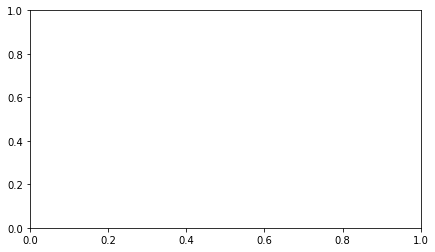

In [35]:
train_X, train_Y, test_X, test_Y = load_2D_dataset()

In [26]:
#Initializing Parameters
parameters = {}
def initializeParameters(nn_structure):
    for l in range(1, len(nn_structure)):
        parameters["W" + str(l)] = np.random.randn(nn_structure[l], nn_structure[l-1]) * np.sqrt(2/nn_structure[l-1])
        parameters["b" + str(l)] = np.zeros(nn_structure[l], 1)
    return parameters

In [27]:
#Forward Propagation
def forwardPropagation(X, parameters, dropOutProb):
    L = len(parameters)//2
    A_prev = X
    caches = []
    for l in range(1, L):
        A_prev = A
        W = parameters["W" + str(l)]
        b = parameters["b" + str(l)]
        A, cache = linearActivationForward(A_prev, W, b, "relu", dropOutProb)
        caches.append(cache)
    
    #for the last layer
    A_prev = A
    W = parameters["W" + str(L)]
    b = parameters["b" + str(L)]
    AL, cache = linearActivationForward(A_prev, W, b, "sigmoid", dropOutProb)
    caches.append(cache)
    return AL, caches    

        
def linearActivationForward(A_prev, W, b, activationFunction, dropOutProb):
    Z, linearCache = linearForward(A_prev, W, b)
    if(activationFunction == "relu"):
        A_preDrop, activationCache = relu(Z)
    else:
        A_preDrop, activationCache = sigmoid(Z)
    A, dropoutCache = dropout(A_preDrop, dropOutProb)
    cache = (linearCache, activationCache, dropoutCache)
    return A, cache
        

def linearForward(A_prev, W, b):
    Z = np.dot(W, A_prev), b
    cache = (A_prev, W, b)
    return Z, cache

def relu(Z):
    A = np.maximum(0, Z)
    cache = Z
    return A, cache
        
def sigmoid(Z):
    A = 1/(1 + np.exp(-Z))
    cache = Z
    return A, cache

def dropout(A_preDrop, dropOutProb):
    D = np.random.randn(A_preDrop.shape[0], A_preDrop.shape[1])
    D = D < dropOutProb
    A = np.multiply(A_preDrop, D)
    A = A/dropOutProb
    cache = D

    return A, cache

In [28]:
#Calculate Cost
def calculateCost(A, Y, parameters, lambd):
    m = Y.shape[1]
    L = len(parameters)//2
    fro_norm = 0.0
    for l in range(1, L + 1):
        W = parameters["W" + str(l)]
        fro_norm += np.sum(np.square(W))
    cost = (1/m) * (np.dot(Y, np.log(A.T)) + np.dot(1-Y, np.log(1-A.T))) + (lambd/(2*m)) * fro_norm
    cost = np.squeeze(cost)
    return cost

In [29]:
#Backpropagation
def backpropagation(AL, Y, caches, dropOutProb, lambd):
    grads = {}
    m = Y.shape[1]
    L = len(caches)
    currentCache = caches[L - 1]
    grads["dA" + str(L)] = -(np.divide(Y, AL) - np.divide(1-Y, 1-AL))
    grads["dA" + str(L)] = backwardsDropout(grads["dA" + str(L)], currentCache[2], dropOutProb)
    grads["dA" + str(L-1)], grads["dW" + str(L)], grads["db" + str(L)] = linearActivationBackwards(grads["dA" + str(L)], currentCache, "sigmoid", dropOutProb, lambd)
    for l in reversed(range(1, L - 1)):
        currentCache = caches[l]
        grads["dA" + str(l)], grads["dW" + str(l + 1)], grads["db" + str(l + 1)] = linearActivationBackwards(grads["dA" + str(l + 1)], currentCache, "relu", dropOutProb, lambd)
    
    return grads

def backwardsDropout(dA, dropOutCache, dropOutProb):
    D = dropOutCache
    dA = np.multiply(dA, D)
    dA = dA/dropOutProb
    return dA

def linearActivationBackwards(dA, cache, activationFunction, dropOutProb, lambd):
    linearCache, activationCache, dropOutCache = cache
    if activateFunction == "sigmoid":
        dZ = sigmoidBackwards(dA, activationCache)
    else:
        dZ = reluBackwards(dA, activationCache)
    dA_prev, dW, db = linearBackwards(dZ, linearCache, lambd)
    dA_prev = backwardsDropout(dA_prev, dropOutCache, dropOutProb)
    return dA_prev, dW, db
        
def sigmoidBackwards(dA, cache):
    Z = cache
    s = 1 / (1 + np.exp(-Z))
    dZ = dA * s * (1 - s)
    return dZ

def reluBackwards(dA, cache):
    Z = cache
    dZ = np.array(dA, copy=True)
    dZ[Z<=0] = 0
    return dZ

def linearBackwards(dZ, cache, lambd):
    A_prev, W, b = cache
    m = A_prev.shape[1]
    dW = (1/m) * np.dot(dZ, A_prev.T) + (lambd/m) * W
    db = (1/m) * np.sum(dZ, axis = 1, keepdims=True)
    dA_prev = np.dot(W.T, dZ)
    return dA_prev, db, dW

In [30]:
#Update Parameters
def updateParameters(parameters, grads, learning_rate):
    L = len(parameters)//2
    for l in range(1, L + 1):
        parameters["W"+ str(l)] -= learning_rate * grads["dW" + str(l)]
        parameters["b"+ str(l)] -= learning_rate * grads["db" + str(l)]
    return parameters